In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Files
path='/content/drive/My Drive/kiso4'
pd.DataFrame(os.listdir(path),columns=['Files'])

Files
0      fire_images
1  non_fire_images

In [ ]:
train_data_dir =path
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 899 files belonging to 2 classes.
Using 720 files for training.
Found 899 files belonging to 2 classes.
Using 179 files for validation.


In [ ]:
class_names = train.class_names
class_names

['fire_images', 'non_fire_images']

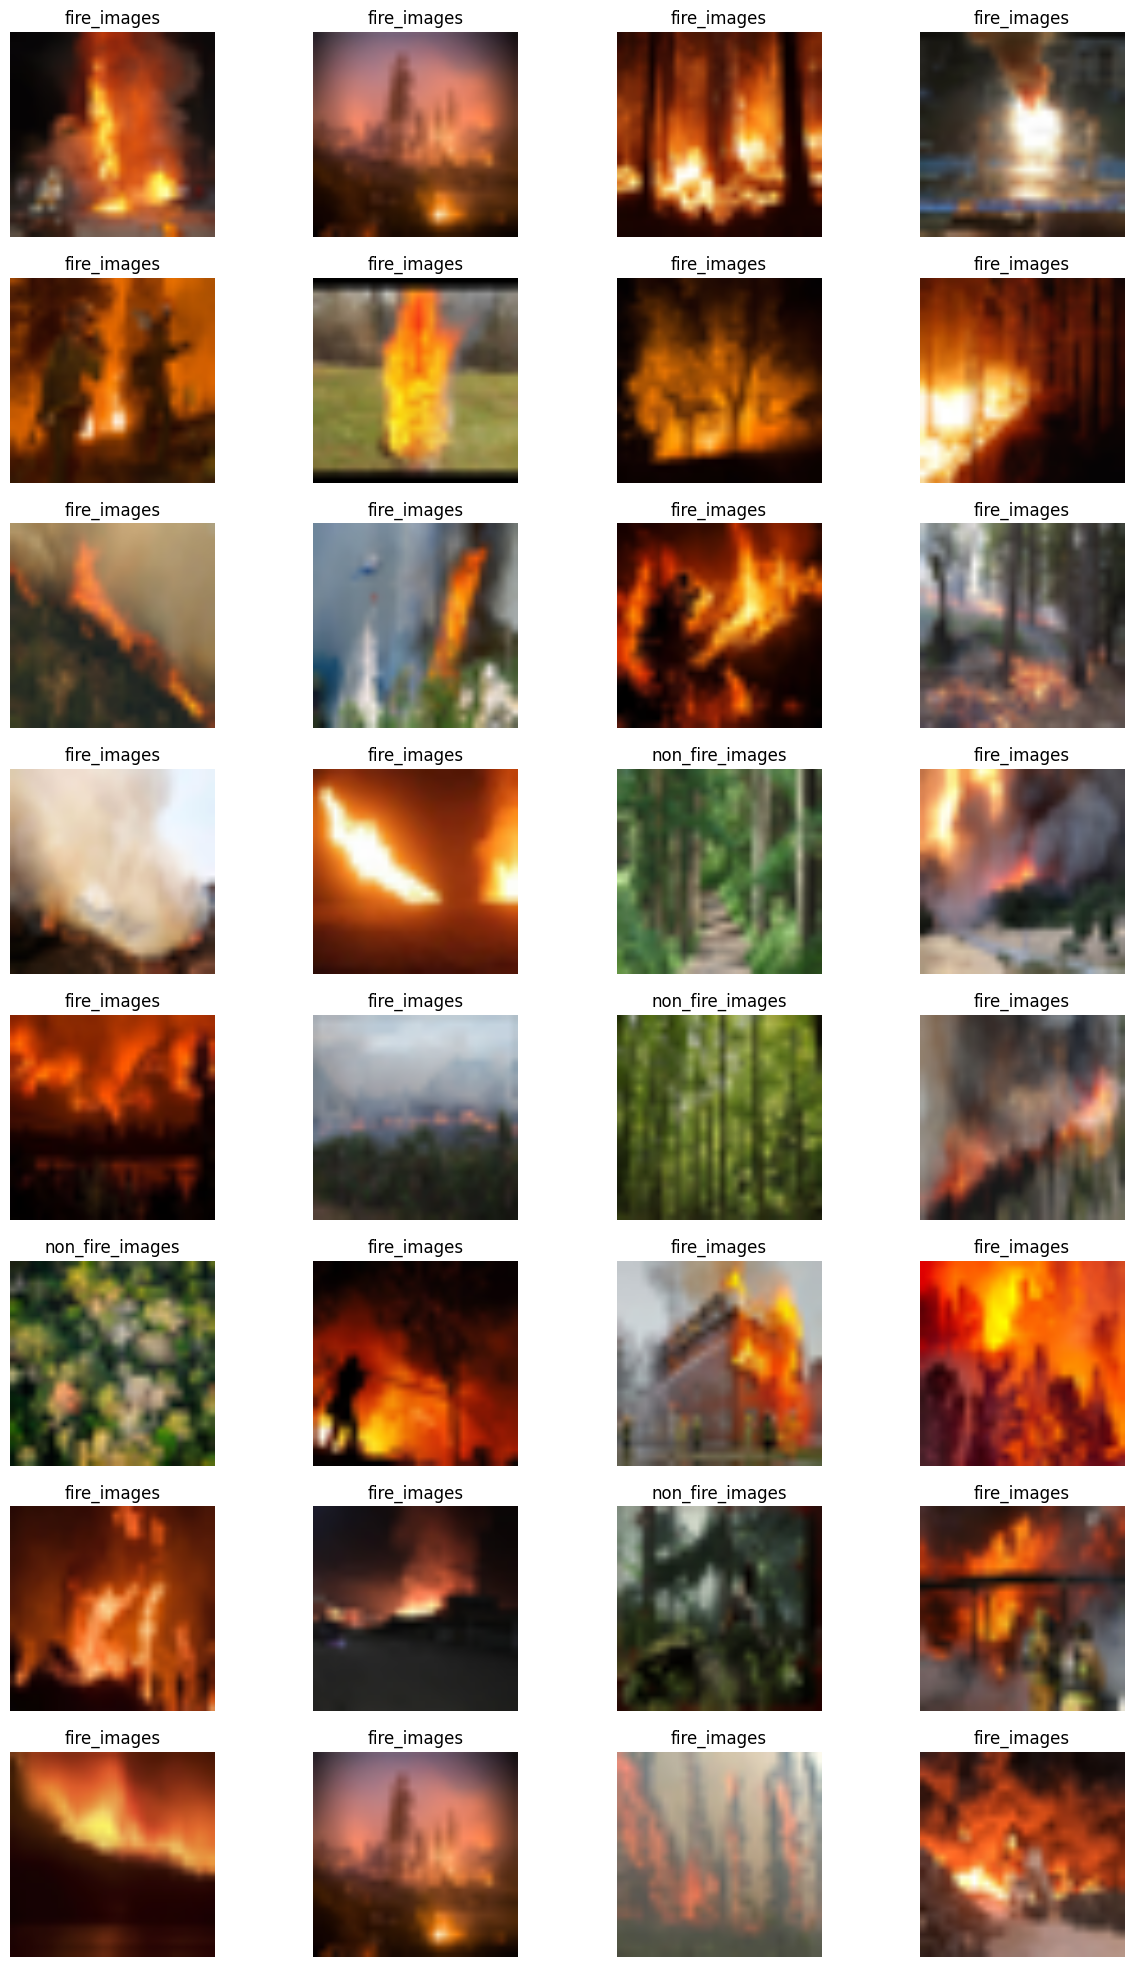

In [ ]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          25,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

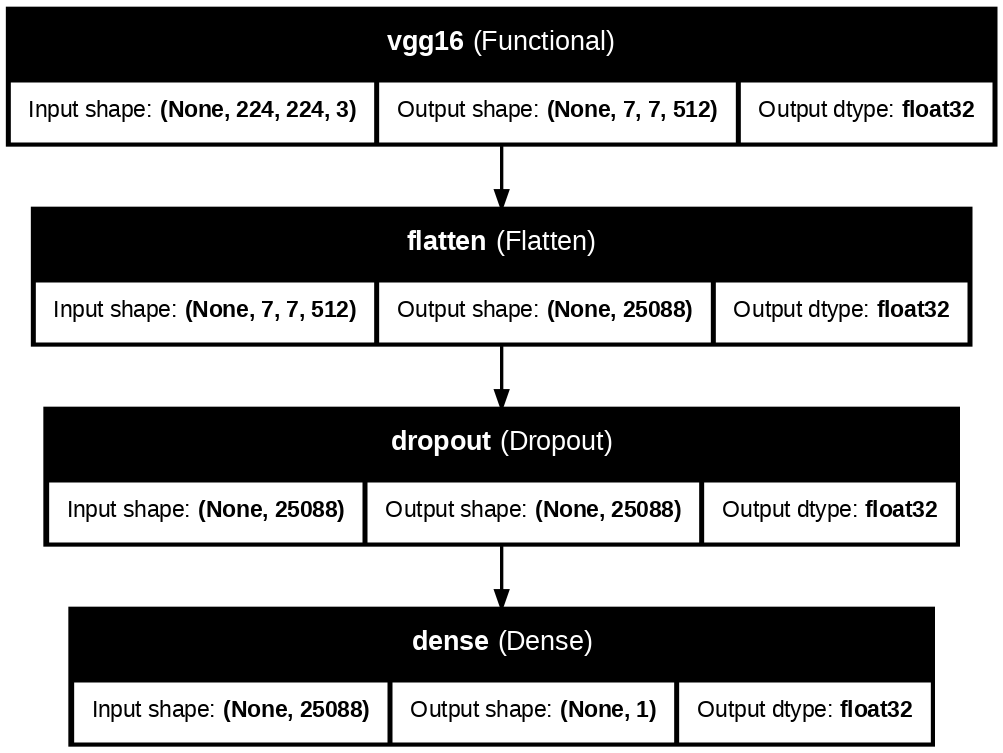

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb = ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Replace fit_generator with fit
hist = model.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7693 - loss: 2.3375

23/23 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.7721 - loss: 2.3077 - val_accuracy: 0.9162 - val_loss: 0.3685
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9446 - loss: 0.2975

23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.9456 - loss: 0.2933 - val_accuracy: 0.9777 - val_loss: 0.1013
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9882 - loss: 0.0443 - val_accuracy: 0.9832 - val_loss: 0.1337
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9961 - loss: 0.0316 - val_accuracy: 0.9888 - val_loss: 0.1039
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9961 - loss: 0.0073 - val_accuracy: 0.9888 - val_loss: 0.1063


In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0  0.837500  1.621943      0.916201  0.368511
1  0.966667  0.198392      0.977654  0.101279
2  0.994444  0.029805      0.983240  0.133685
3  0.997222  0.015274      0.988827  0.103902
4  0.995833  0.006992      0.988827  0.106255

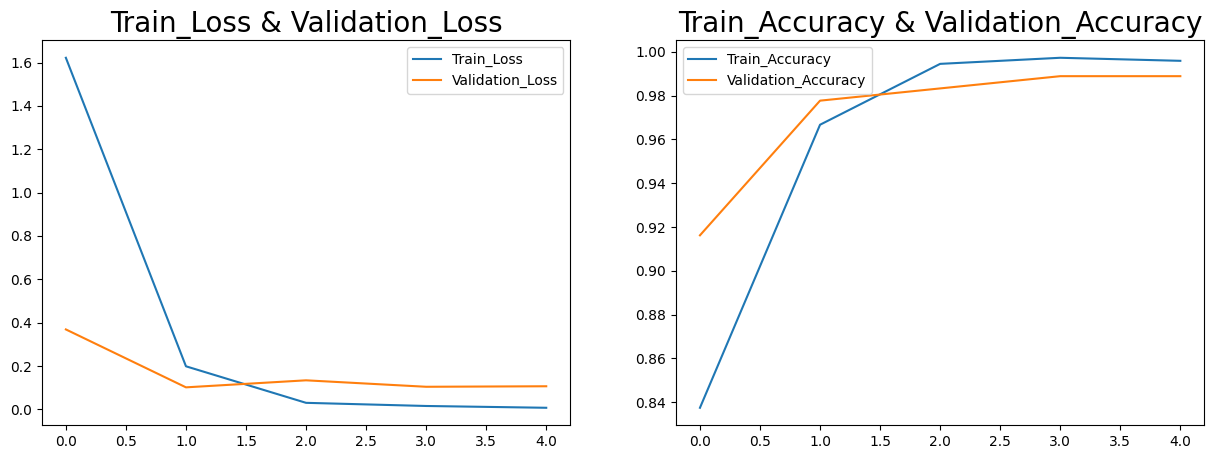

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
X_val,y_val=[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
y_pred=np.where(predictions>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step


Actual  Prediction
0         1           1
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
174       1           1
175       0           0
176       0           0
177       0           0
178       0           0

[179 rows x 2 columns]

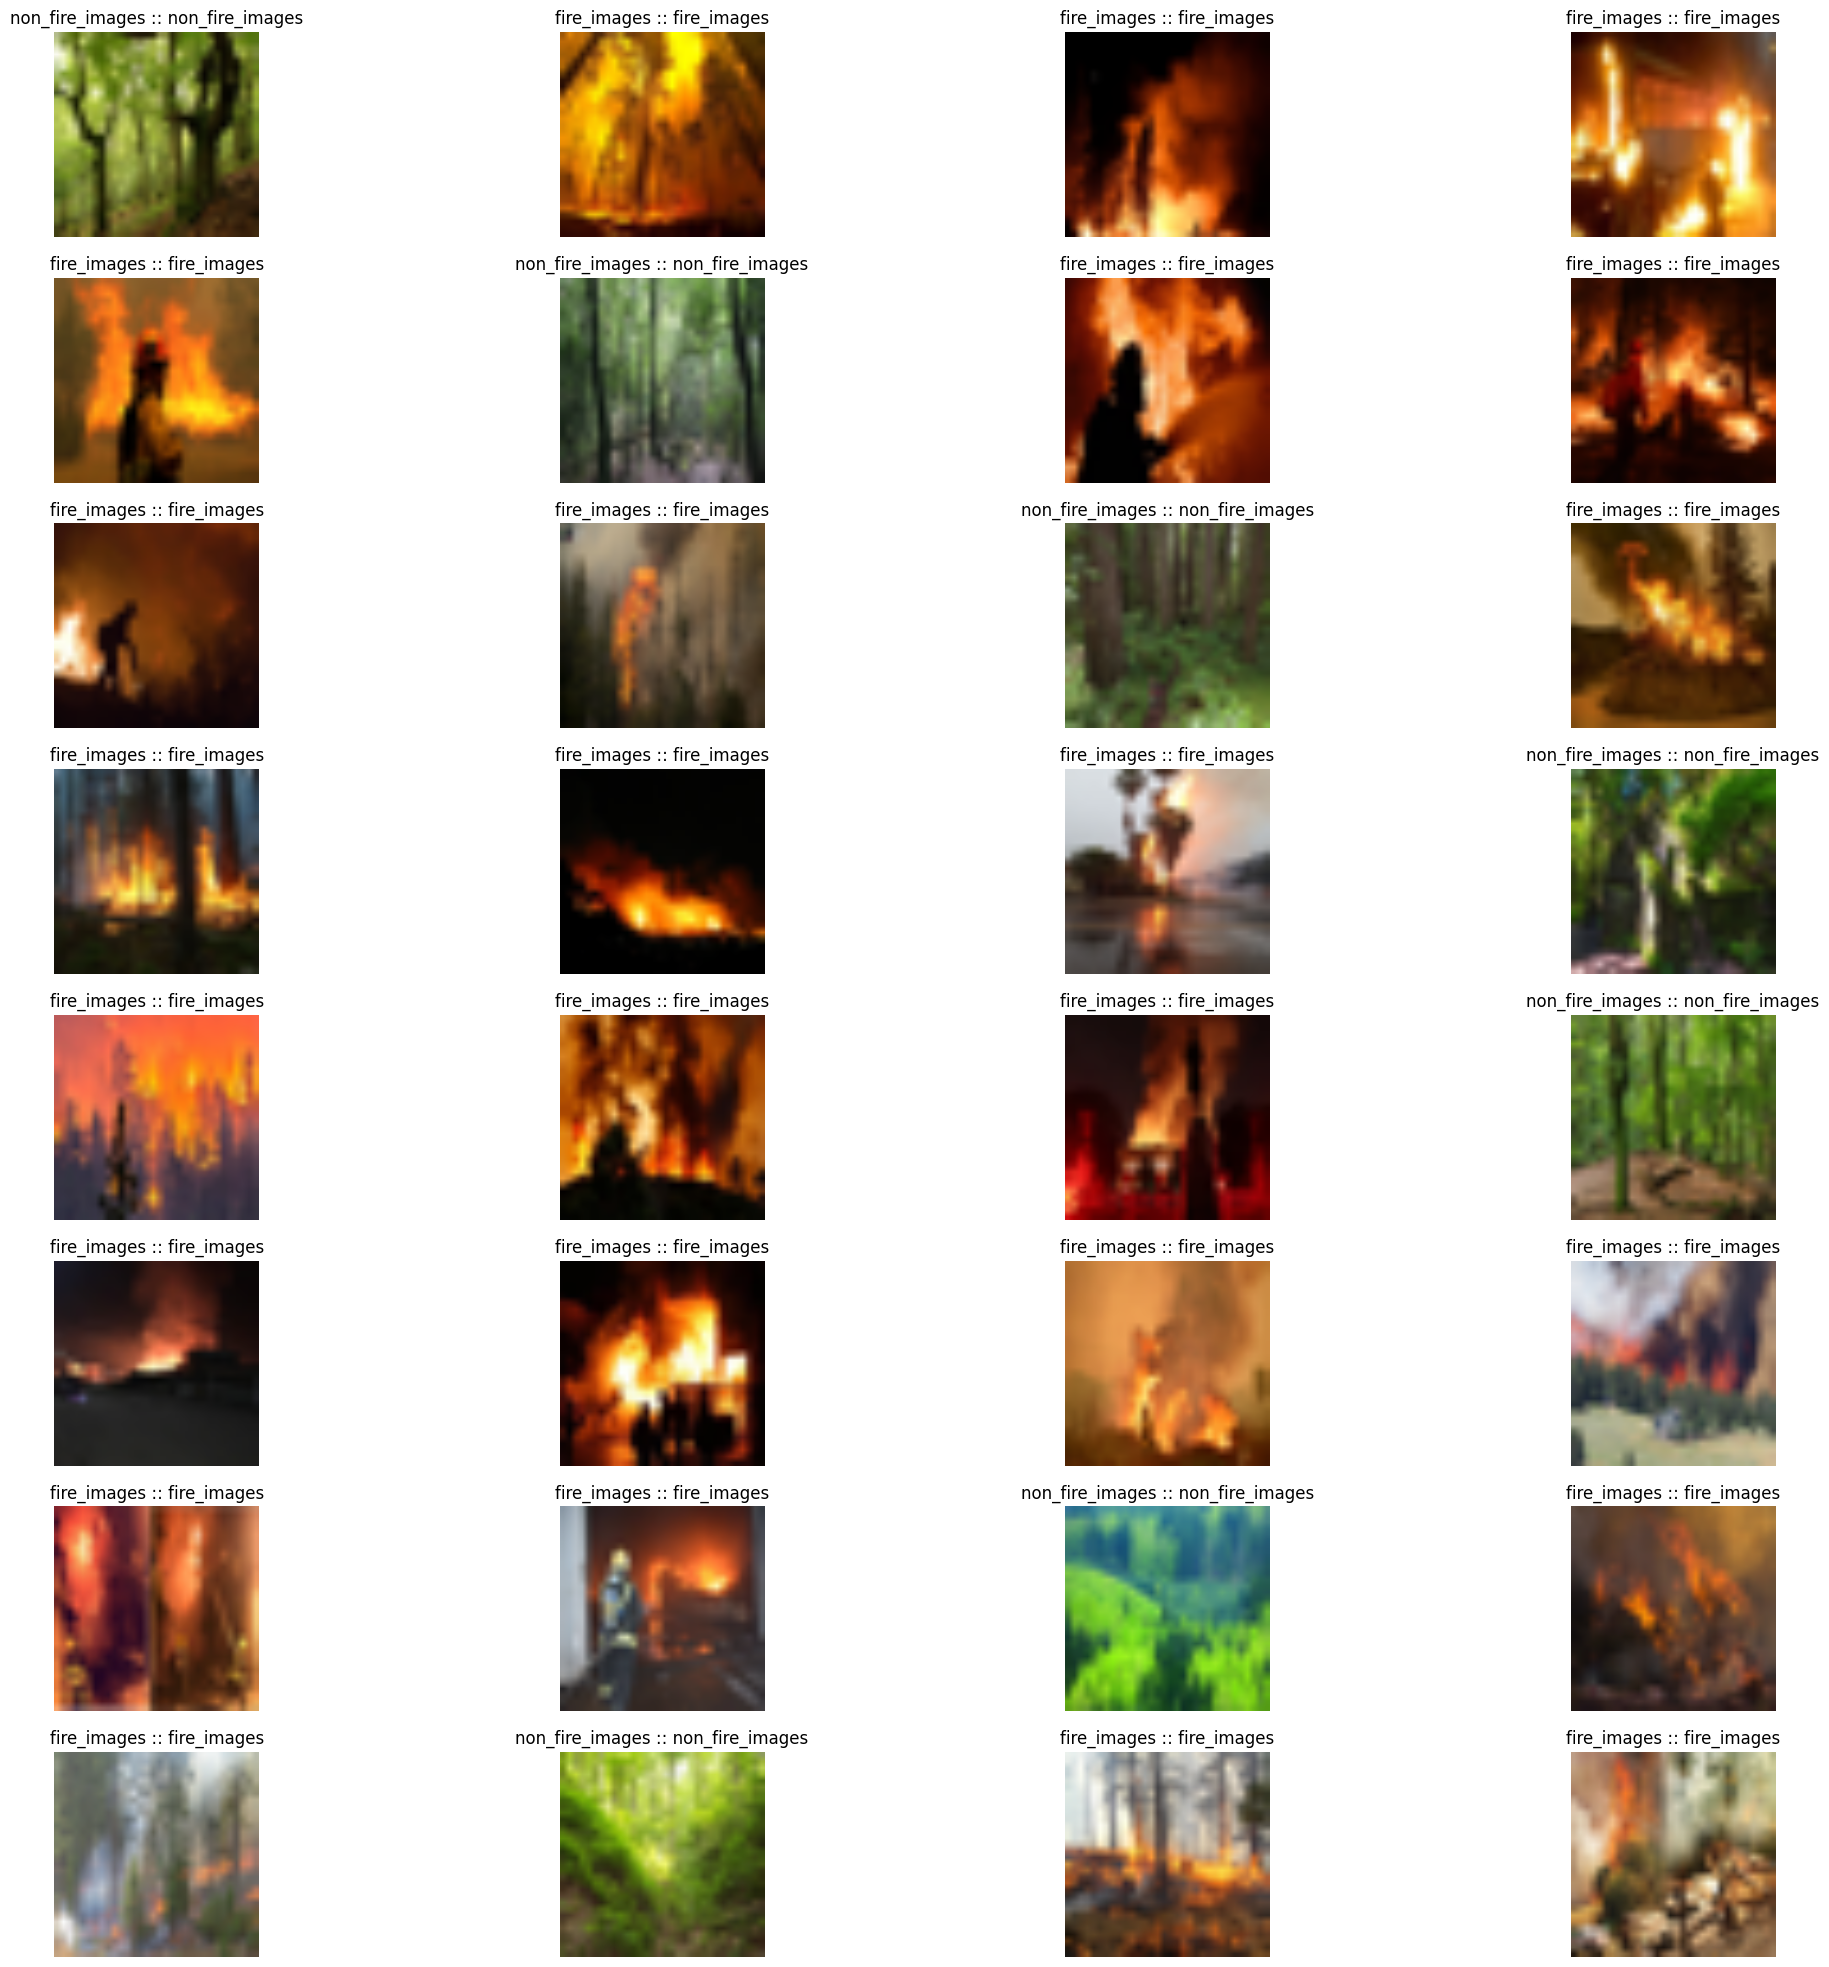

In [ ]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}')
    plt.axis("off")

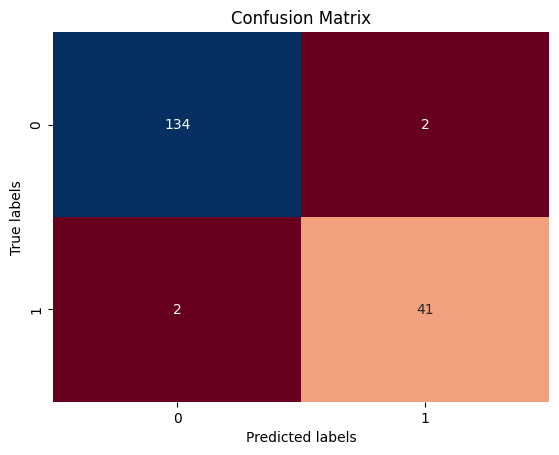

array([[134,   2],
       [  2,  41]])

In [ ]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

In [ ]:
ClassificationReport = classification_report(y_val,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.99      0.99      0.99       136
           1       0.95      0.95      0.95        43

    accuracy                           0.98       179
   macro avg       0.97      0.97      0.97       179
weighted avg       0.98      0.98      0.98       179



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


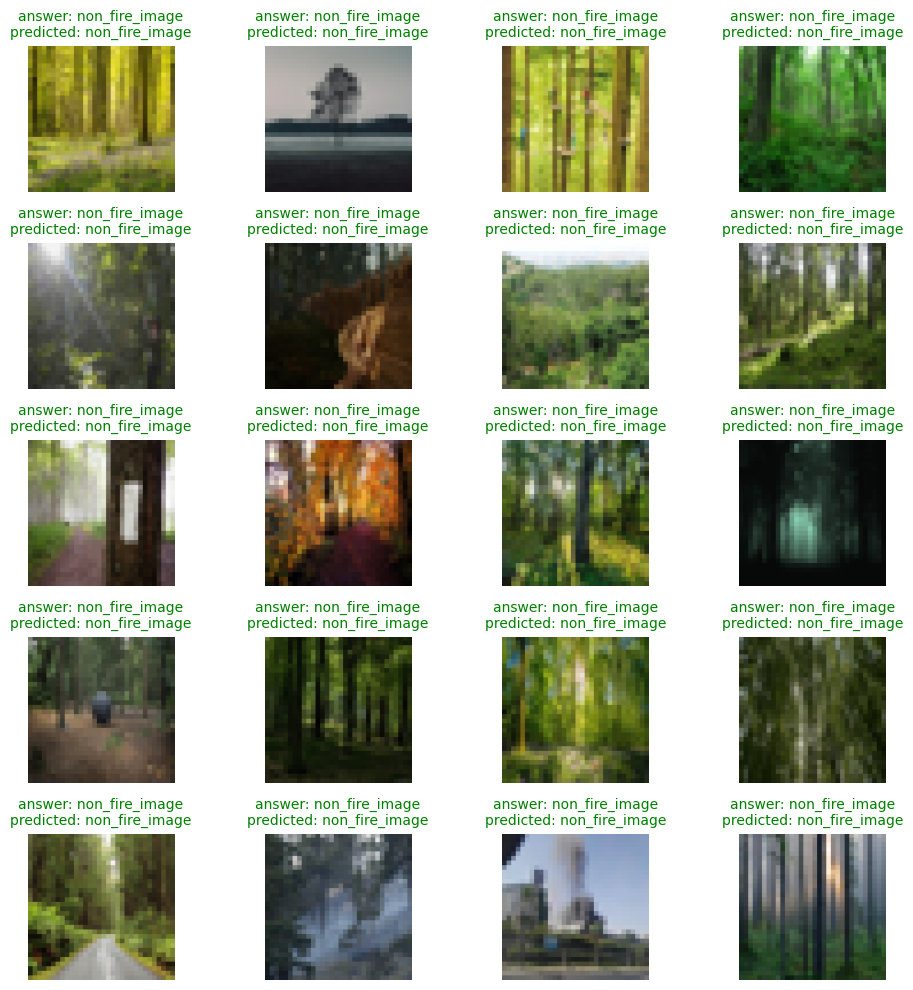

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# テストデータのディレクトリ
test_data_dir = "/content/drive/My Drive/some/test_data"

# 画像サイズ (VGG16の入力サイズ)
img_size = (224, 224)

# 画像ファイル一覧を取得
image_files = [f for f in os.listdir(test_data_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# 画像をリストに格納
X_test = []
file_names = []

for file in image_files:
    img_path = os.path.join(test_data_dir, file)
    img = load_img(img_path, target_size=img_size)  # 画像を読み込み
    img_array = img_to_array(img) / 255.0  # 正規化（0〜1）
    X_test.append(img_array)
    file_names.append(file)

# NumPy配列に変換
X_test = np.array(X_test)

# モデルで予測
y_pred = model.predict(X_test)



# クラス名を設定
classes = ["fire_image", "non_fire_image"]

# 予測ラベル（0 or 1）
y_pred_labels = (y_pred >= 0.5).astype(int).flatten()

# 正解ラベル（本来は用意する必要があるが、ここでは仮のデータ）
y_true_labels = np.zeros_like(y_pred_labels)  # 例: 全て non_fire_image と仮定

# もしラベルが逆だった場合
y_true_labels = 1 - y_true_labels  # 🔄 0 ↔ 1 を入れ替える

# 画像とラベルを表示
num_images = min(20, len(X_test))  # 最大 20 枚まで表示
plt.figure(figsize=(10, 10))

for i in range(num_images):
    plt.subplot(5, 4, i + 1)  # 5行4列のグリッド
    plt.imshow(X_test[i])  # 画像を表示
    plt.axis("off")  # 軸を非表示

    # 予測が正しければ緑、間違っていれば赤
    color = "green" if y_pred_labels[i] == y_true_labels[i] else "red"

    # タイトルに正解ラベルと予測ラベルを表示
    plt.title(f"answer: {classes[y_true_labels[i]]}\npredicted: {classes[y_pred_labels[i]]}",
              color=color, fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# prompt: 画像分類結果の精度を表示する

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Accuracy on test data: {accuracy}")


Accuracy on test data: 0.98


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# ディレクトリのパス
directory = "/content/drive/My Drive/some/test_data"

# ファイル一覧を取得
files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])

# 画像と名前を表示
for file in files:
    file_path = os.path.join(directory, file)
    img = mpimg.imread(file_path)
    plt.figure()
    plt.imshow(img)
    plt.title(file)
    plt.axis('off')  # 軸を非表示
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/some/test_data'